<a href="https://colab.research.google.com/github/AsadShibli/Image-Classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

[link text](https://)# From Colab

### make sure the dataset is uploaded in your drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Projects/Garbage Image Classification

[Errno 2] No such file or directory: '/content/drive/MyDrive/Projects/Garbage Image Classification'
/content


In [ ]:
!unzip -q "archive (2).zip"

# From Kaggle

first create API , then paste the kaggle.json file to the colab

In [ ]:
%cd /content/

/content


In [ ]:
# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to the .kaggle directory
!cp /content/kaggle.json ~/.kaggle/

# Set the permissions for the kaggle.json file to ensure it is readable
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle  datasets download -d farzadnekouei/trash-type-image-dataset  # copy the API command from specific dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
 39% 16.0M/40.9M [00:00<00:00, 163MB/s]
100% 40.9M/40.9M [00:00<00:00, 245MB/s]


In [ ]:
# !unzip "/content/trash-type-image-dataset.zip" -d "/content/drive/MyDrive/Projects/Garbage Image Classification"

# Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [ ]:
%cd /content/drive/MyDrive/Projects/Garbage Image Classification

/content/drive/MyDrive/Projects/Garbage Image Classification


In [ ]:
# Define your project name
project_name = 'Full_Garbage_Image_Classifcation'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/drive/MyDrive/Projects/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation


### the dataset structure :
  TrashType_Image_Dataset:
*   all classes
  *   images corresponding their class

#### we want the folder to be this format:

TrashType_split_dataset:
*   train
  *   all classes
    * images corresponding their class
*   test
  *   all classes
    * images corresponding their class

# Diving the dataset into train and test folder

In [ ]:
import os
import shutil
import random

# Define paths to your original dataset and the new train/test directories
original_dataset_dir = 'TrashType_Image_Dataset'  # The directory with your 5 class folders
base_dir = 'TrashType_split_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create the base directory
os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the split ratio for training and testing
train_split = 0.8

# List the class names
class_names = os.listdir(original_dataset_dir)

# Create class directories in the train and test directories
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Function to split and copy images
def split_and_copy_images(class_name):
    class_dir = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)
    split_index = int(train_split * len(images))

    train_images = images[:split_index]
    test_images = images[split_index:]

    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_dir, class_name, image)
        shutil.copyfile(src, dst)

    for image in test_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        shutil.copyfile(src, dst)

# Split and copy images for each class
for class_name in class_names:
    split_and_copy_images(class_name)

print("Dataset split into training and testing sets.")


Dataset split into training and testing sets.


# Data Cleaning

### checking all images are in correct format or not

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = 'TrashType_split_dataset/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

#### Defining a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.

In [ ]:
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = 'TrashType_split_dataset/train'
test_dir = 'TrashType_split_dataset/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       cardboard  glass  metal  paper  plastic  trash
train        322    400    328    475      385    109
      cardboard  glass  metal  paper  plastic  trash
test         81    101     82    119       97     28


#### Paper type trash is the most represented class, while the lowest is regular trash, indicating a clear class imbalance.

<Axes: >

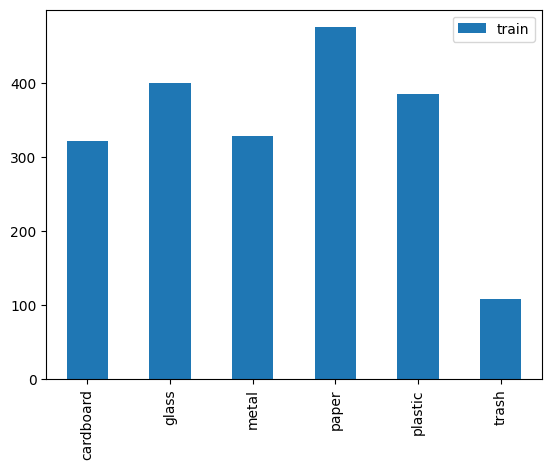

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

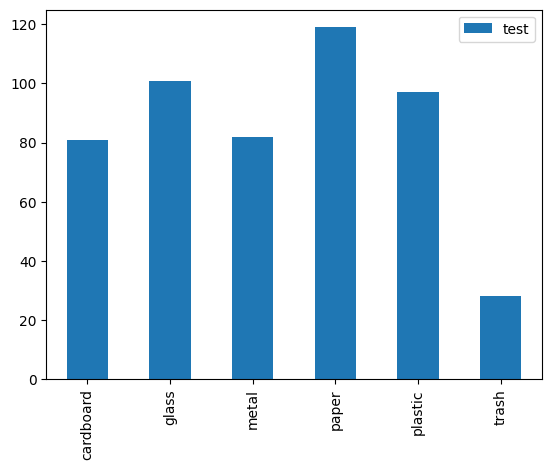

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each Trash.

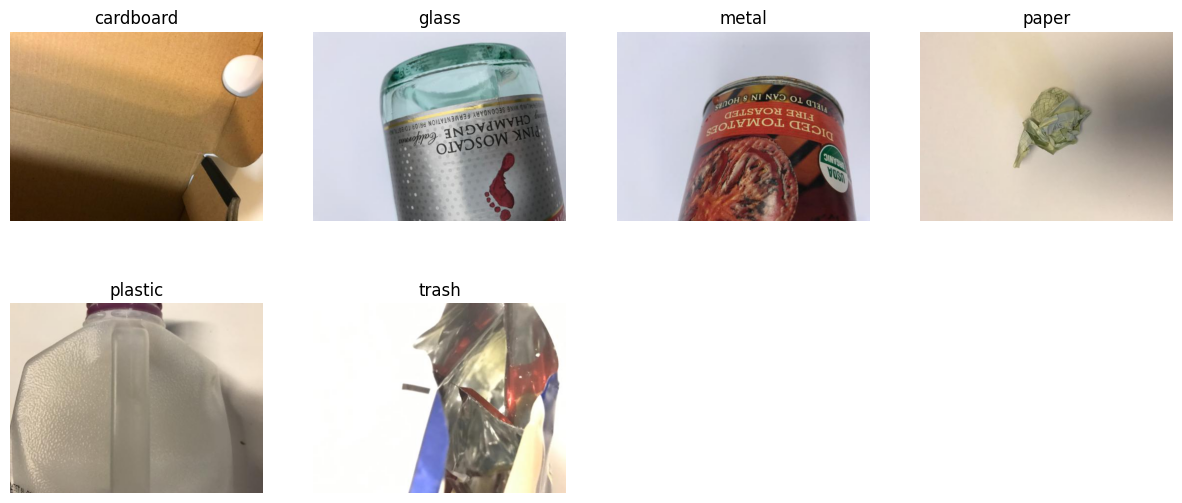

In [ ]:
trashes = os.listdir(data_dir)
plt.figure(figsize=(15,10))

for i, trash in enumerate(trashes, 1):
    folder = os.path.join(data_dir, trash)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(trash)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

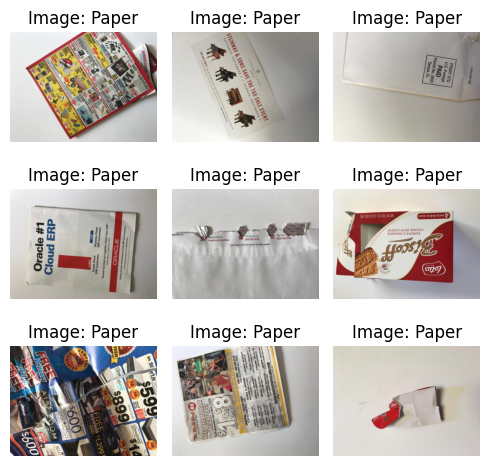

In [ ]:
# Placeholder for the directory path
paper_directory_path = 'TrashType_split_dataset/train/paper'  # Replace with your directory path
plot_images_from_directory(paper_directory_path, class_name = 'Paper')

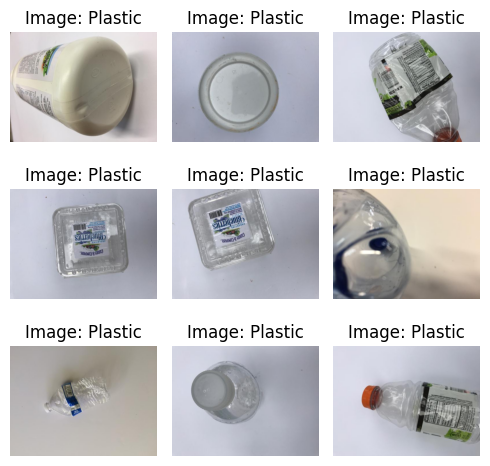

In [ ]:
# Placeholder for the directory path
plastic_directory_path = 'TrashType_split_dataset/train/plastic'  # Replace with your directory path
plot_images_from_directory(plastic_directory_path, class_name = 'Plastic')

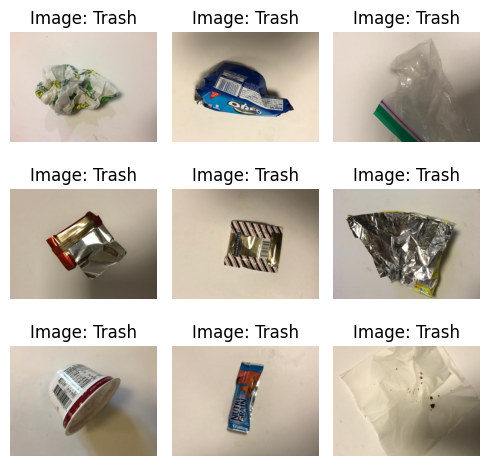

In [ ]:
# Placeholder for the directory path
trash_directory_path = 'TrashType_split_dataset/train/trash'  # Replace with your directory path
plot_images_from_directory(trash_directory_path, class_name = 'Trash')

# Checking shapes and channels.

In [ ]:
image = 'TrashType_split_dataset/train/trash/trash_001.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (384, 512, 3)


In [ ]:
import cv2

image_path = 'TrashType_split_dataset/train/trash/trash_001.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (384, 512)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
# Define paths to the train and validation directories
train_data_dir = 'TrashType_split_dataset/train'
test_data_dir = 'TrashType_split_dataset/test'

In [ ]:
# Set some parameters
img_width, img_height = 128 , 128  # Size of images
batch_size = 32
epochs = 10
num_classes = 6  # Update this based on the number of your classes

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 1617 images belonging to 6 classes.
Found 402 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Count the number of samples in each class for the training set
train_class_counts = np.zeros(len(class_labels))
for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    train_class_counts += y_batch.sum(axis=0)

# Count the number of samples in each class for the validation set
validation_class_counts = np.zeros(len(class_labels))
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    validation_class_counts += y_batch.sum(axis=0)

# Print the counts
print("Training set class distribution:")
for label, count in zip(class_labels, train_class_counts):
    print(f"{label}: {int(count)}")

print("\nValidation set class distribution:")
for label, count in zip(class_labels, validation_class_counts):
    print(f"{label}: {int(count)}")


Training set class distribution:
cardboard: 258
glass: 320
metal: 263
paper: 380
plastic: 308
trash: 88

Validation set class distribution:
cardboard: 64
glass: 80
metal: 65
paper: 95
plastic: 77
trash: 21


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Validation class labels: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Validation class labels: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
# Initialize the CNN
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 activation_32 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 activation_33 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 activation_32 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 activation_33 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                

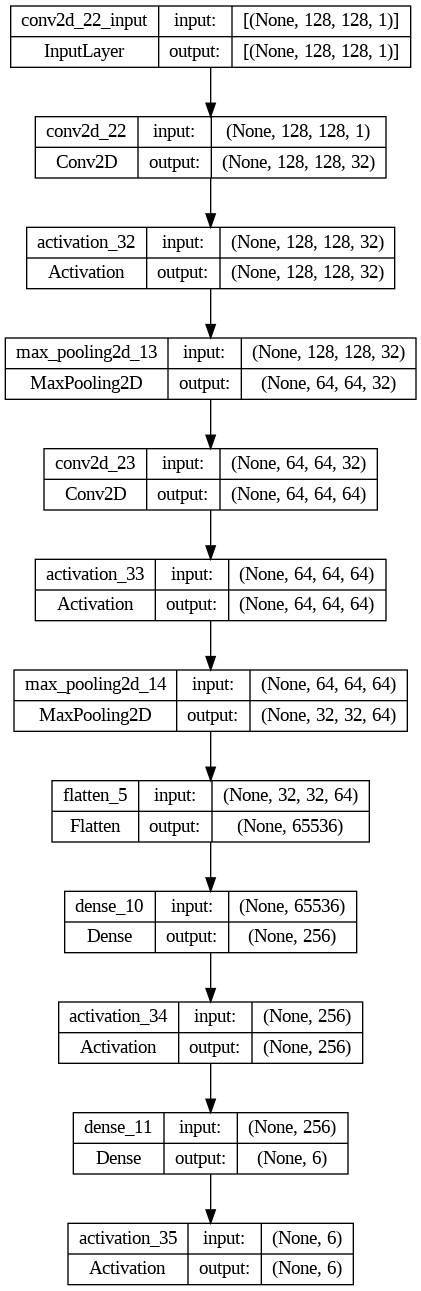

In [ ]:
plot_model(model, to_file = '/content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Understanding Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

# Calculating Steps for epoch

In [ ]:
train_generator.samples

1617

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
50/51 [============================>.] - ETA: 0s - loss: 1.7565 - accuracy: 0.2454
Epoch 1: val_loss improved from inf to 1.63423, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_From_Scratch/Custom_CNN_model.keras
51/51 [==============================] - 13s 215ms/step - loss: 1.7557 - accuracy: 0.2455 - val_loss: 1.6342 - val_accuracy: 0.2488 - lr: 1.0000e-04
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.5594 - accuracy: 0.3340
Epoch 2: val_loss improved from 1.63423 to 1.52242, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_From_Scratch/Custom_CNN_model.keras
51/51 [==============================] - 13s 251ms/step - loss: 1.5594 - accuracy: 0.3340 - val_loss: 1.5224 - val_accuracy: 0.3930 - lr: 1.0000e-04
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.4758 - accuracy: 0.3871
Epoch 3: val_loss improved from 1.52242 to 1.48150, saving model

# Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

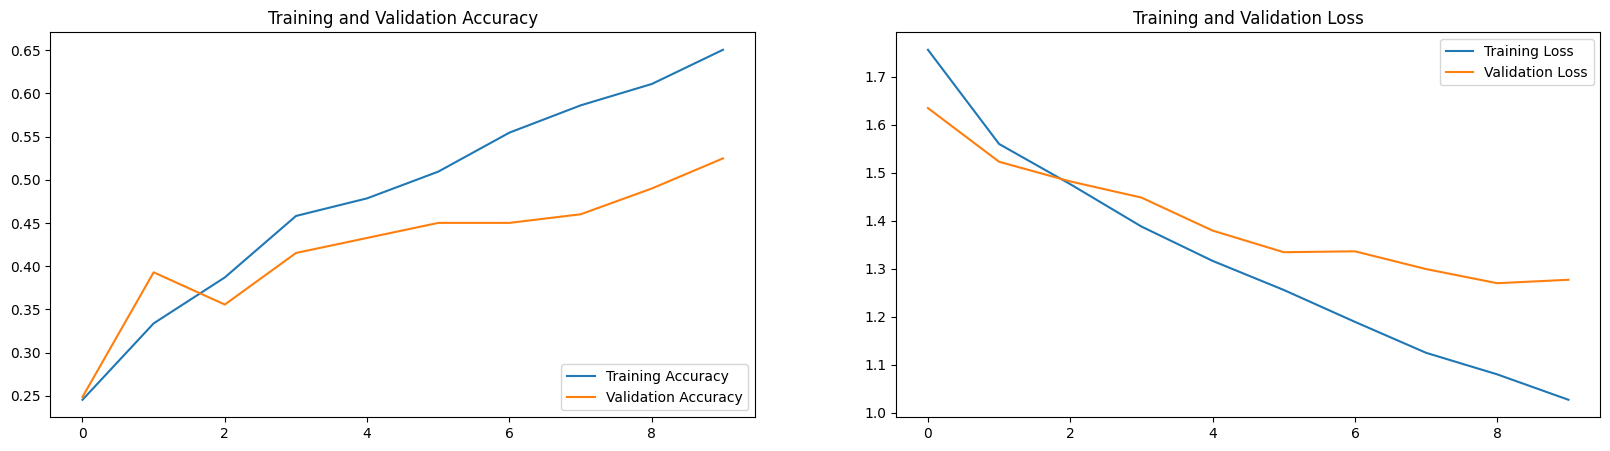

In [ ]:
plot_training_history(history)

#### The plot indicates overfitting; the training accuracy curve is rising, while the validation accuracy is declining. Similarly, in the loss curve plot, the training loss decreases, but the validation loss increases.

# Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

16/16 [==============================] - 351s 23s/step - loss: 1.3770 - accuracy: 0.4862
final train accuracy = 68.46 , validation accuracy = 48.62


# Plotting Confusion Matrix

16/16 [==============================] - 5s 257ms/step


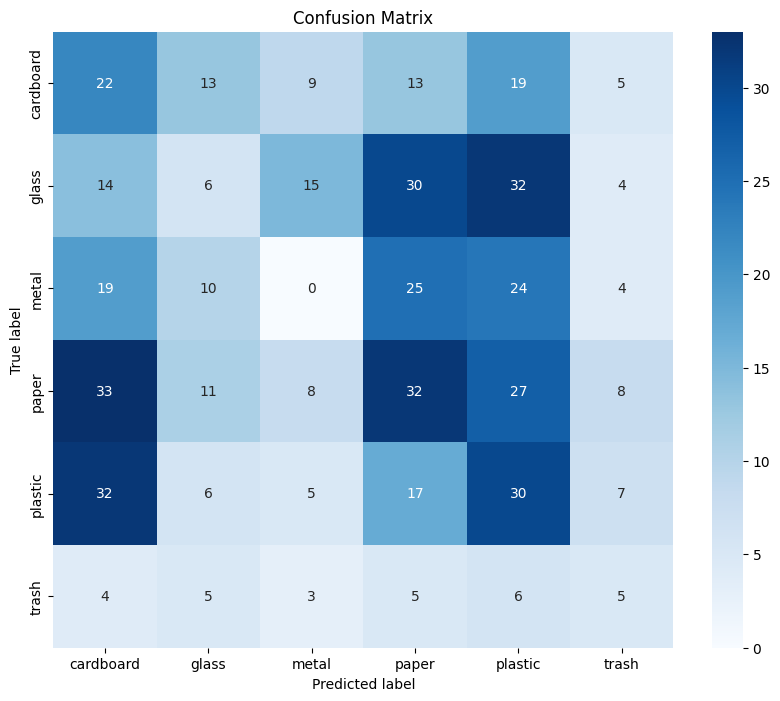

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

####  In the confusion matrix, the diagonal values are not high, indicating that the model frequently misclassifies instances across different classes. This suggests that the model's performance is poor.

# Making Predictions

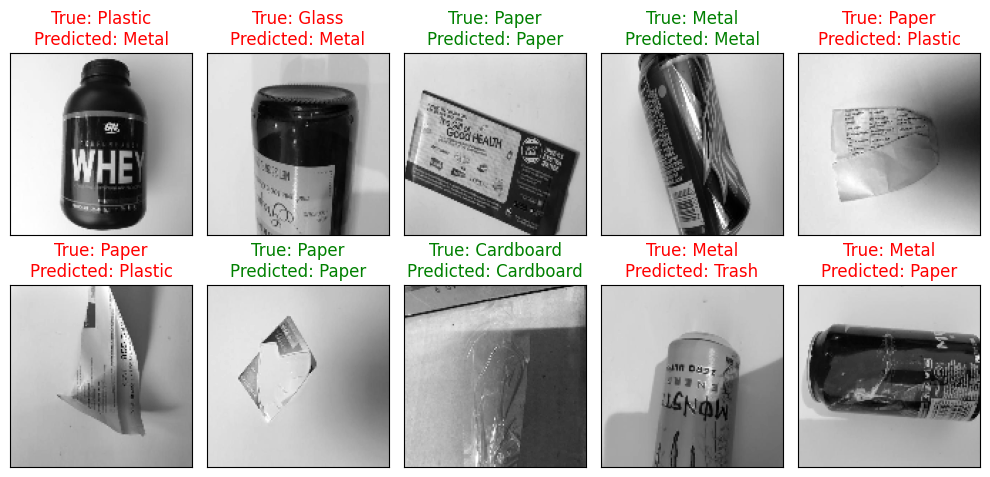

In [ ]:
# Trash classes for the dataset
Trash_Classes = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Trash_Classes[Random_Img_Label] == Trash_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Trash_Classes[Random_Img_Label]}\nPredicted: {Trash_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [ ]:
# Define paths to the train and validation directories
train_data_dir = 'TrashType_split_dataset/train'
test_data_dir = 'TrashType_split_dataset/test'

# Set some parameters
img_width, img_height = 128, 128  # Size of images
batch_size = 32
epochs = 10
num_classes = 6  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 1617 images belonging to 6 classes.
Found 402 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


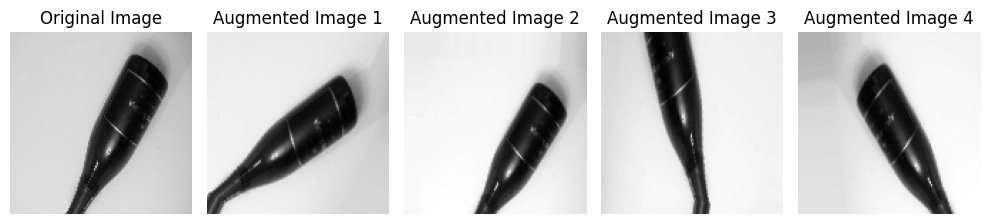

In [ ]:
# Path to your specific image
image_path = '/content/drive/MyDrive/Projects/Garbage Image Classification/TrashType_split_dataset/train/glass/glass_007.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch
    # save image
    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the CNN
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)


# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.2424
Epoch 1: val_loss improved from inf to 1.67864, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
51/51 [==============================] - 19s 305ms/step - loss: 1.7182 - accuracy: 0.2424 - val_loss: 1.6786 - val_accuracy: 0.2786 - lr: 1.0000e-04
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.6266 - accuracy: 0.2814
Epoch 2: val_loss improved from 1.67864 to 1.61812, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
51/51 [==============================] - 14s 271ms/step - loss: 1.6266 - accuracy: 0.2814 - val_loss: 1.6181 - val_accuracy: 0.2935 - lr: 1.0000e-04
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.6009 - accuracy: 0.3253
Epoch 3: val_loss improved from 1.

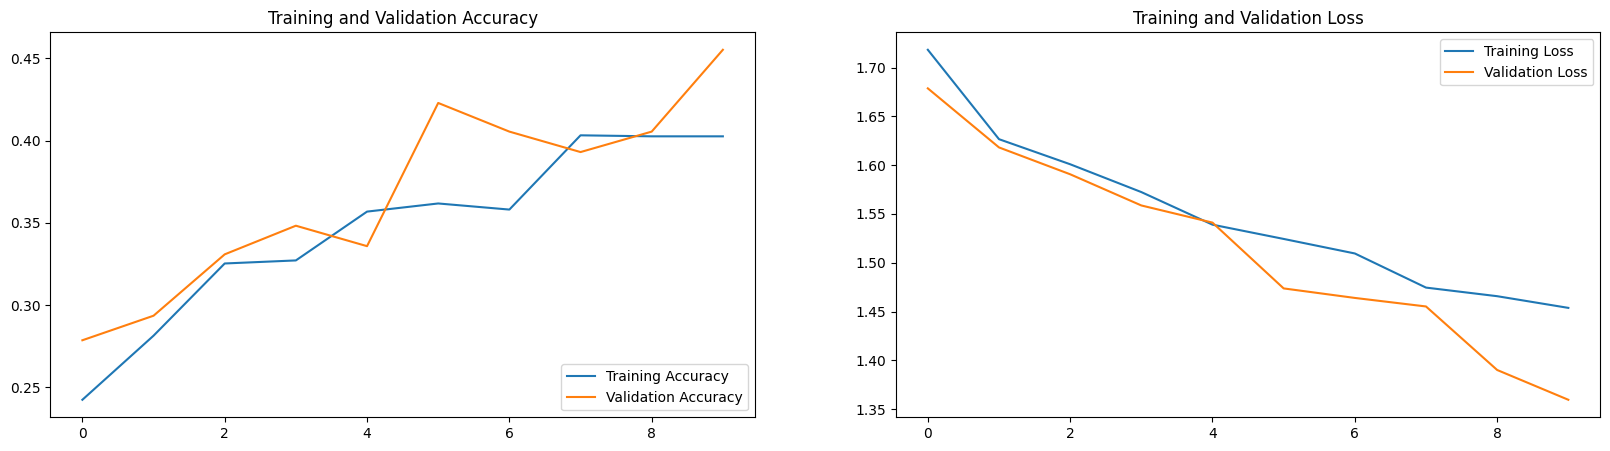

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

16/16 [==============================] - 2s 140ms/step - loss: 1.4434 - accuracy: 0.4055
final train accuracy = 41.37 , validation accuracy = 40.55


####  Although the accuracy decreased, the model has become more generalized.

16/16 [==============================] - 3s 175ms/step


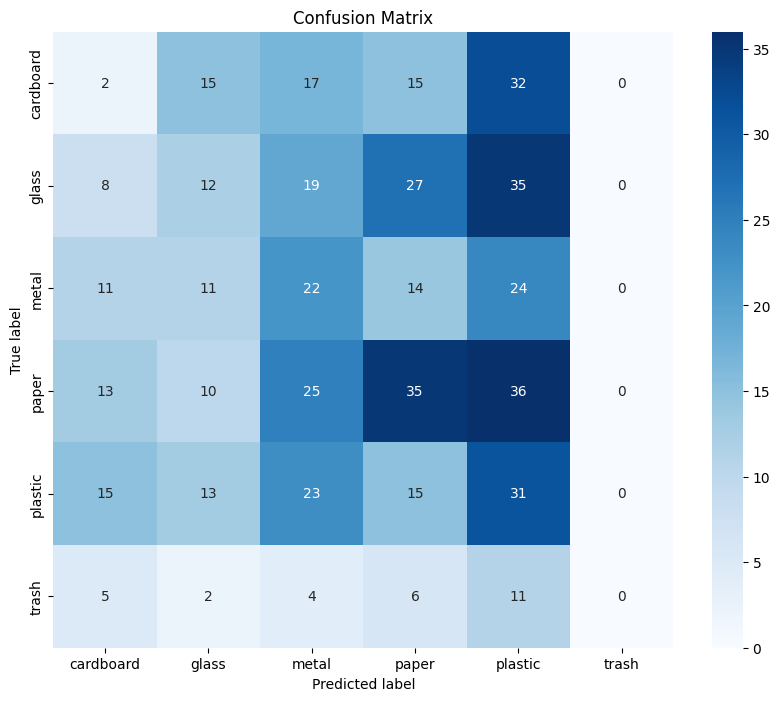

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### The confusion matrix reveals a significant issue: the model makes zero predictions for the trash class. Therefore, we need to explore a different approach.

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.04      0.02      0.03        81
       glass       0.19      0.12      0.15       101
       metal       0.20      0.27      0.23        82
       paper       0.31      0.29      0.30       119
     plastic       0.18      0.32      0.23        97
       trash       0.00      0.00      0.00        28

    accuracy                           0.20       508
   macro avg       0.15      0.17      0.16       508
weighted avg       0.18      0.20      0.19       508



# Model 3: Transfer Learning VGGNET

In [ ]:
# Define paths to the train and validation directories
train_data_dir = 'TrashType_split_dataset/train'
test_data_dir = 'TrashType_split_dataset/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 6  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.045031055900621, 1: 0.84125, 2: 1.0259146341463414, 3: 0.708421052631579, 4: 0.874025974025974, 5: 3.0871559633027523}


In [ ]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [ ]:
classes = 6

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(6, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=25,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 1.7945 - accuracy: 0.3091
Epoch 1: val_loss improved from inf to 1.23907, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
32/32 [==============================] - 82s 2s/step - loss: 1.7945 - accuracy: 0.3091 - val_loss: 1.2391 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 1.2982 - accuracy: 0.4785
Epoch 2: val_loss improved from 1.23907 to 0.95657, saving model to /content/drive/MyDrive/Projects/Full_Garbage_Image_Classifcation/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
32/32 [==============================] - 48s 1s/step - loss: 1.2982 - accuracy: 0.4785 - val_loss: 0.9566 - val_accuracy: 0.6280 - lr: 1.0000e-04
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.6043
Epoch 3: val_loss improved from 0.95657 to 0.87740, savi

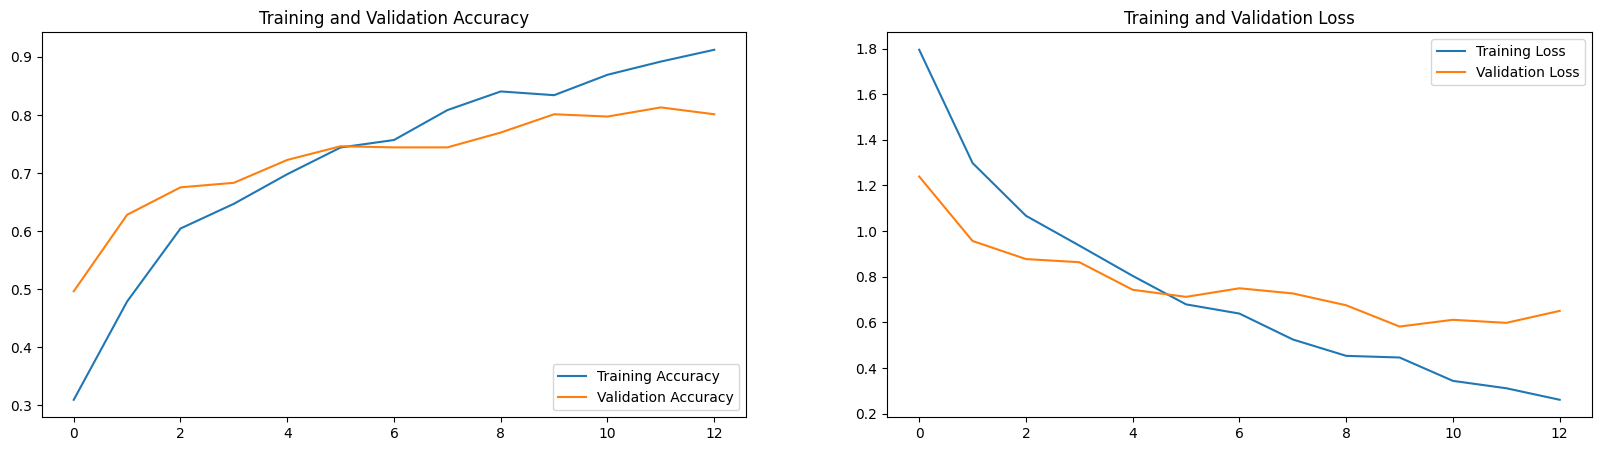

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

8/8 [==============================] - 3s 406ms/step - loss: 0.5817 - accuracy: 0.8012
final train accuracy = 90.54 , validation accuracy = 80.12


8/8 [==============================] - 3s 352ms/step


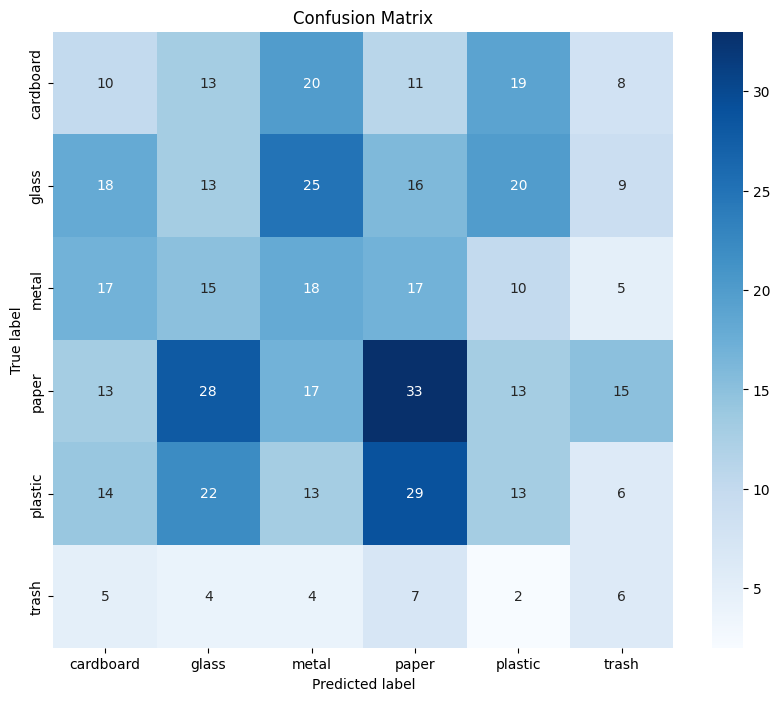

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### VGG achieves excellent accuracy and generalization compared to our Model 1 and Model 2. However, let's also try our 4th model to explore further options.

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.13      0.12      0.13        81
       glass       0.14      0.13      0.13       101
       metal       0.19      0.22      0.20        82
       paper       0.29      0.28      0.28       119
     plastic       0.17      0.13      0.15        97
       trash       0.12      0.21      0.16        28

    accuracy                           0.18       508
   macro avg       0.17      0.18      0.18       508
weighted avg       0.19      0.18      0.18       508



# Model 4 : Transfer Leanring - ResNet50

In [ ]:
# Directory paths for training and testing data
train_dir = 'TrashType_split_dataset/train'
test_dir = 'TrashType_split_dataset/test'

# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


# Introducing Class wieghts for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.045031055900621, 1: 0.84125, 2: 1.0259146341463414, 3: 0.708421052631579, 4: 0.874025974025974, 5: 3.0871559633027523}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Count the number of layers in the model
num_layers = len(ResNet50V2.layers)
print(f'The number of layers in ResNet50V2 is: {num_layers}')

The number of layers in ResNet50V2 is: 190


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(6,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/temp/Full_Garbage_Image_Classifcation/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss',
                             save_weights_only=True)

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=30,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 1.5254 - accuracy: 0.4780 
Epoch 1: val_loss improved from inf to 3.86553, saving model to /content/drive/MyDrive/temp/Full_Garbage_Image_Classifcation/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
32/32 [==============================] - 808s 25s/step - loss: 1.5254 - accuracy: 0.4780 - val_loss: 3.8655 - val_accuracy: 0.2854
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.9602 - accuracy: 0.6587
Epoch 2: val_loss did not improve from 3.86553
32/32 [==============================] - 42s 1s/step - loss: 0.9602 - accuracy: 0.6587 - val_loss: 5.7935 - val_accuracy: 0.2835
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7573
Epoch 3: val_loss improved from 3.86553 to 2.77493, saving model to /content/drive/MyDrive/temp/Full_Garbage_Image_Classifcation/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
32/32 [=============================

In [ ]:
model.save("Test_model.keras")

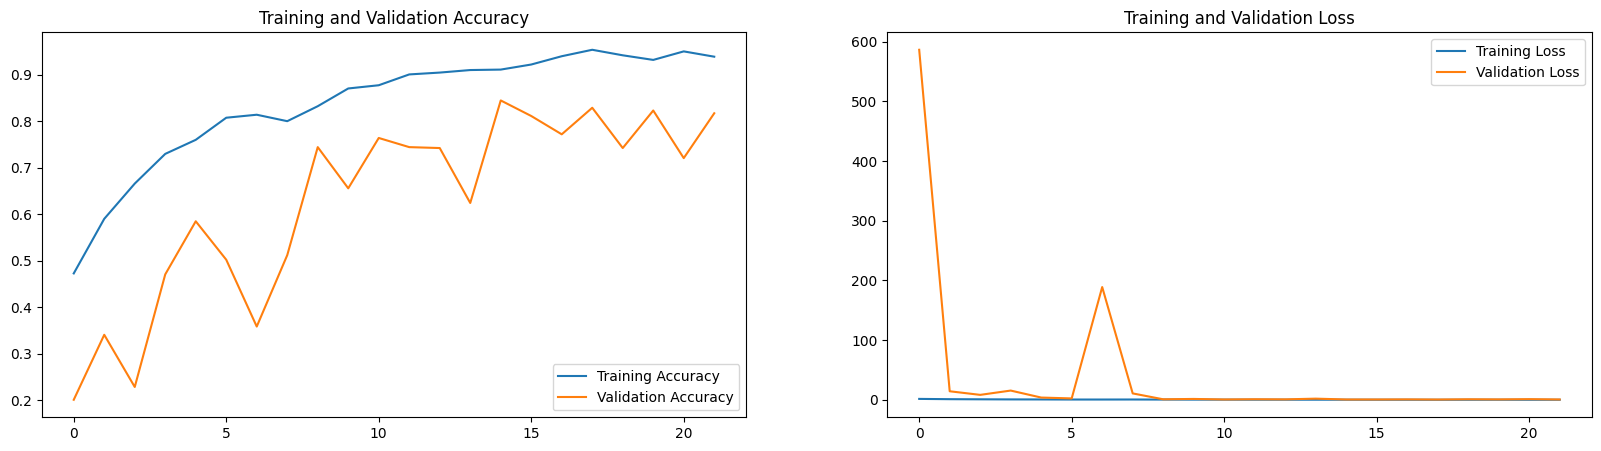

In [ ]:
plot_training_history(train_history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

8/8 [==============================] - 3s 345ms/step - loss: 0.6445 - accuracy: 0.8445
final train accuracy = 94.06 , validation accuracy = 84.45


# Now , Let's visualize the Confusion Matrix

#### A confusion matrix is important in image classification as it provides a detailed breakdown of the model's performance. It displays the counts of true positives, true negatives, false positives, and false negatives, enabling a clear understanding of how well the model distinguishes between different classes and highlighting specific areas where the model may be making errors.

8/8 [==============================] - 4s 354ms/step


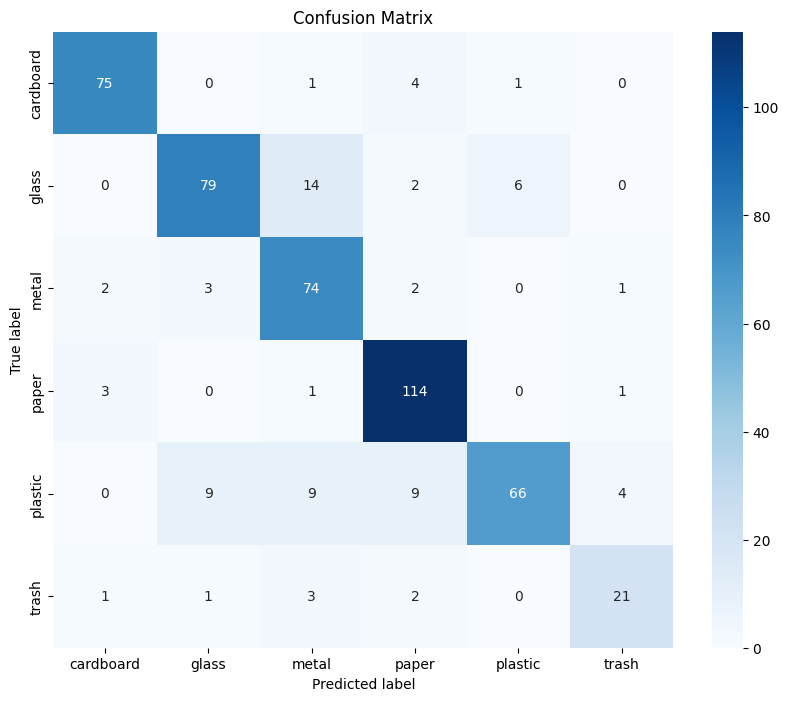

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Finally, our 4th model outperformed the previous three models in terms of accuracy and generalization. We are satisfied with this model for now.

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.93      0.93      0.93        81
       glass       0.86      0.78      0.82       101
       metal       0.73      0.90      0.80        82
       paper       0.86      0.96      0.90       119
     plastic       0.90      0.68      0.78        97
       trash       0.78      0.75      0.76        28

    accuracy                           0.84       508
   macro avg       0.84      0.83      0.83       508
weighted avg       0.85      0.84      0.84       508



# AUC ROC plot for each class

#### The AUC-ROC curve is crucial in image classification as it evaluates the performance of the classification model. The ROC curve plots the true positive rate against the false positive rate, while the AUC (Area Under the Curve) quantifies the overall ability of the model to distinguish between classes, providing a single metric to compare different models.

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

8/8 [==============================] - 3s 413ms/step


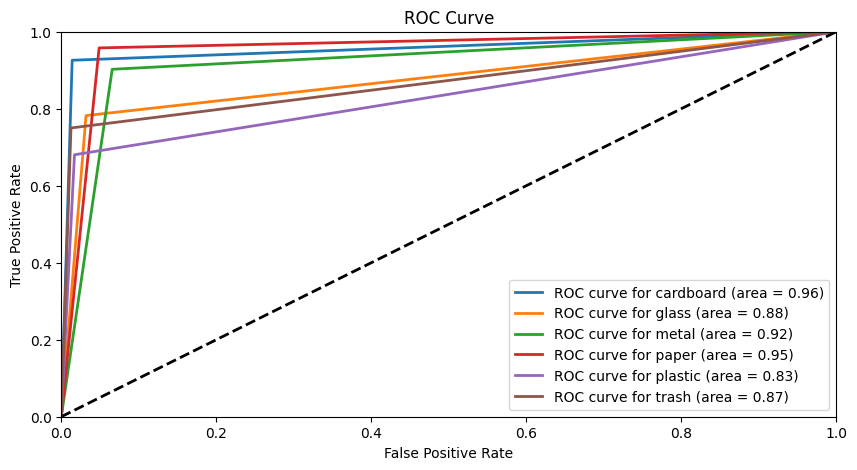

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save("Resnet_model_version_2.keras")

# Making Predictions

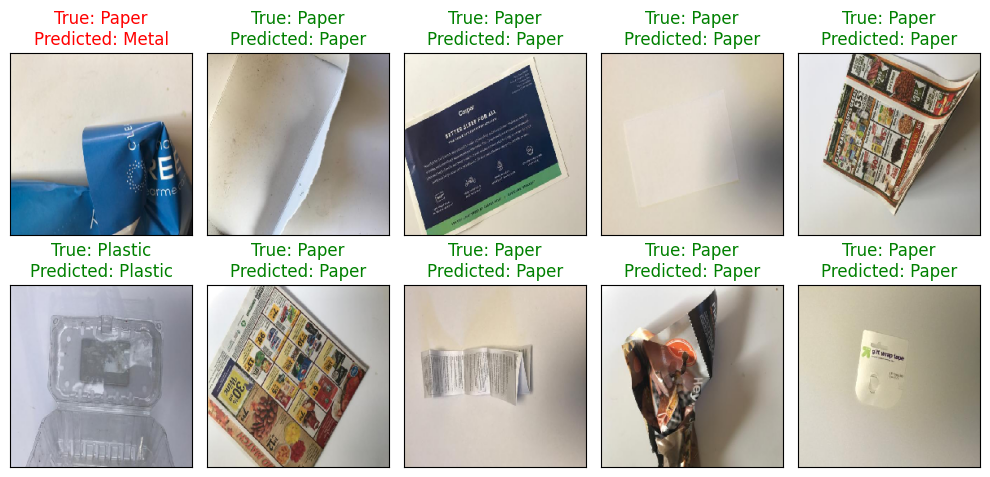

In [ ]:
# Trash classes for the dataset
Trash_Classes = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Trash_Classes[Random_Img_Label] == Trash_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Trash_Classes[Random_Img_Label]}\nPredicted: {Trash_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Testing with a random Image

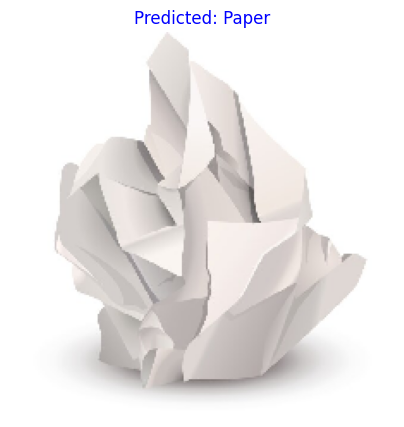

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming Trash_classes and model are already defined
Trash_Classes = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

def predict_custom_image(image_path):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust target_size as per your model's input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to fit the model's input format

    # Normalize the image if required (depends on the preprocessing done during training)
    img_array /= 255.0

    # Make a prediction using the model
    prediction = np.argmax(model.predict(img_array, verbose=0), axis=1)[0]

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {Trash_Classes[prediction]}", color="blue")
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/paper.jpg'  # Replace with the path to your custom image
predict_custom_image(image_path)


# Deployement

In [1]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 780.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.0 MB

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [6]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/temp/Resnet_model_version_2.keras')

In [9]:
# Trash labels dictionary
trash_labels = {'Cardboard': 0, 'Glass': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Trash': 5}
index_to_trash = {v: k for k, v in trash_labels.items()}
index_to_trash

{0: 'Cardboard', 1: 'Glass', 2: 'Metal', 3: 'Paper', 4: 'Plastic', 5: 'Trash'}

In [10]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_trash(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the trash label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_trash = index_to_trash.get(predicted_class[0], "Unknown Trash")
    return predicted_trash

interface = gr.Interface(
    fn=predict_trash,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted trash
    title="Trash  Classification",
    description="Upload an image and see the predicted trash."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b4c77ccf8943085d62.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
